<a href="https://colab.research.google.com/github/niv19960/Song-Lyrics-NLP-/blob/main/NN_lyrics_santiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
# Data structures
import pandas as pd
import numpy as np

# Pre-processing and Tokenization
import string
import gensim
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

# Embedding 
# Using GloVe Embeddings
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

import zipfile
from zipfile import *
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

# Build the model 
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import CSVLogger

# Plot results
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


--2022-07-20 06:19:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-20 06:19:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-20 06:19:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
def processTrainingData(df):
    # Initializes training data, stop words list and translator for stripping punctuation
    X_data = []
    y_data = df["Mood"]
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)

    for lyric in df.lyrics:
        
        # Tokenize each lyric, and set all characters to lower-case
        tokens = word_tokenize(lyric)
        tokens = [word.lower() for word in tokens]
        
        # Remove punctuation
        tokens_nopunc = [word.translate(translator) for word in tokens]
        
        # Remove non-alphabetic tokens
        words = [word for word in tokens_nopunc if word.isalpha()]
        
        # Remove stop words from the lyric
        words = [word for word in words if not word in stop_words]
        
        # Append to training data
        X_data.append(words)


    # Map each word token in the training data to an integer

    Vocab_size = 1000
    oov_token = "<OOV>"

    # For each training example, maps each word token to an integer
    tokenizer = Tokenizer(num_words = Vocab_size, oov_token=oov_token) 
    tokenizer.fit_on_texts(X_data)
    X_data_seq = tokenizer.texts_to_sequences(X_data)


    # Pad sequences shorter than max length 
    max_num_tokens = max([len(tokenized_lyric) for tokenized_lyric in X_data])
    X_data_seq_padded = pad_sequences(X_data_seq, maxlen=max_num_tokens)
    
    return X_data_seq_padded, y_data, tokenizer.word_index ,max_num_tokens

def preTrainedGloVeEmbedding(word_index):
    # Loads pre-trained GloVe word embeddings

    # Load in GloVe file and initialize embedding index
    embeddings_index = {}
    file = open('/tmp/glove/glove.6B.100d.txt')
    embeddings_index = {}

    for line in file:
        
        # Add each embedding to the embedding index
        embedding = line.split()
        embeddings_index[embedding[0]] = np.asarray(embedding[1:])

    file.close() 

    # Map GloVe word embeddings to each word in the tokenizer word index to create a matrix of word embeddings

    # Initialize embedding matrix
    embedding_dim = 100
    vocab_num_words = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_num_words, embedding_dim))

    # Populate embedding matrix
    for word, i in word_index.items():
        
        if i > vocab_num_words:
            continue
            
        # Assign corresponding GloVe embedding to the given word
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            # Words not found in the embedding are assigned a zero vector by default
            embedding_matrix[i] = embedding_vector

    return vocab_num_words, embedding_dim, embedding_matrix

def trainTestSplit(X_data_seq_padded, y_data):
    # Shuffles the data, and splits it into train and test sets

    VALIDATION_SPLIT = 0.3

    # Shuffles data and labels
    word_indices = np.arange(X_data_seq_padded.shape[0])
    np.random.shuffle(word_indices)
    X_data_seq_padded = X_data_seq_padded[word_indices]
    moods = np.array(y_data)
    moods = moods[word_indices]

    # Binarizes the mood labels
    encoder = LabelBinarizer()
    moods = encoder.fit_transform(moods.tolist())

    # Splits the dataset into train and test sets
    num_validation_samples = int(VALIDATION_SPLIT * X_data_seq_padded.shape[0])
    X_train_pad = X_data_seq_padded[:-num_validation_samples]
    y_train = moods[:-num_validation_samples]

    X_test_pad = X_data_seq_padded[-num_validation_samples:]
    y_test = moods[-num_validation_samples:]
    return X_train_pad, X_test_pad, y_train, y_test


def SecModel(X_train_pad,X_test_pad,y_train,y_test,vocab_num_words,embedding_dim,embedding_matrix,max_num_tokens):

    # Defines the Binary model, compiles and trains it

    model = Sequential() 
    embedding_layer = Embedding(vocab_num_words, 
                                embedding_dim, 
                                embeddings_initializer=Constant(embedding_matrix), 
                                input_length=max_num_tokens,
                                trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128,  return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Saves a History object for plotting
    history = model.fit(X_train_pad, y_train, batch_size=128, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

    return model , history,X_test_pad, y_test 

def plotConfusionMatrix(model1, X_test_pad, y_test):

  # Gets predicted labels from model
  y_pred = np.around(model1.predict(X_test_pad)).astype(int).flatten()
  print (y_pred.shape)
  # Generates confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Formats and displays the confusion matrix
  figure(num=None, figsize=(3, 2), dpi=300)
  df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'], columns = ['Negative', 'Positive'])
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap=plt.cm.Blues, fmt='g', cbar=False)
  plt.title('Binary Classification Confusion Matrix', fontsize=15)
  plt.xlabel("Predicted Class", fontsize=12)
  plt.ylabel("Actual Class", fontsize=12)
  plt.show()

def plotTrainingModelaccuracy(history):
  """
  Plot accuracy as a function of training epoch
  """

  figure(num=None, figsize=(3,2), dpi=300)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid(True)
  plt.title('Binary Classification Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def saveModelInfo(model, history):
  
  """
  Take the model and the history results of it as parameters.
  Save the model 
  Save the results and weights of the model
  """

  # Create history df and save as csv file 
  hist_df = pd.DataFrame(history.history) 
  hist_csv_file = 'history.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)

  # Save weights
  weight = model.get_weights()
  np.savetxt('weights.csv' , weight , fmt='%s', delimiter=',')

  # Save results of the model 
  filename='log.csv'
  history_logger=CSVLogger(filename, separator=",", append=True)

  # Save the model itself
  model.save("lyrics_mood_model")



Epoch 1/10
88/88 - 19s - loss: 0.6117 - accuracy: 0.6744 - val_loss: 0.5831 - val_accuracy: 0.7098 - 19s/epoch - 221ms/step
Epoch 2/10
88/88 - 8s - loss: 0.5636 - accuracy: 0.7234 - val_loss: 0.5490 - val_accuracy: 0.7298 - 8s/epoch - 87ms/step
Epoch 3/10
88/88 - 8s - loss: 0.5352 - accuracy: 0.7411 - val_loss: 0.5234 - val_accuracy: 0.7492 - 8s/epoch - 88ms/step
Epoch 4/10
88/88 - 8s - loss: 0.5339 - accuracy: 0.7421 - val_loss: 0.5283 - val_accuracy: 0.7477 - 8s/epoch - 88ms/step
Epoch 5/10
88/88 - 8s - loss: 0.5242 - accuracy: 0.7521 - val_loss: 0.5247 - val_accuracy: 0.7496 - 8s/epoch - 89ms/step
Epoch 6/10
88/88 - 8s - loss: 0.5113 - accuracy: 0.7554 - val_loss: 0.5375 - val_accuracy: 0.7546 - 8s/epoch - 89ms/step
Epoch 7/10
88/88 - 8s - loss: 0.5020 - accuracy: 0.7579 - val_loss: 0.5302 - val_accuracy: 0.7521 - 8s/epoch - 90ms/step
Epoch 8/10
88/88 - 9s - loss: 0.4852 - accuracy: 0.7694 - val_loss: 0.5211 - val_accuracy: 0.7552 - 9s/epoch - 97ms/step
Epoch 9/10
88/88 - 8s - loss:

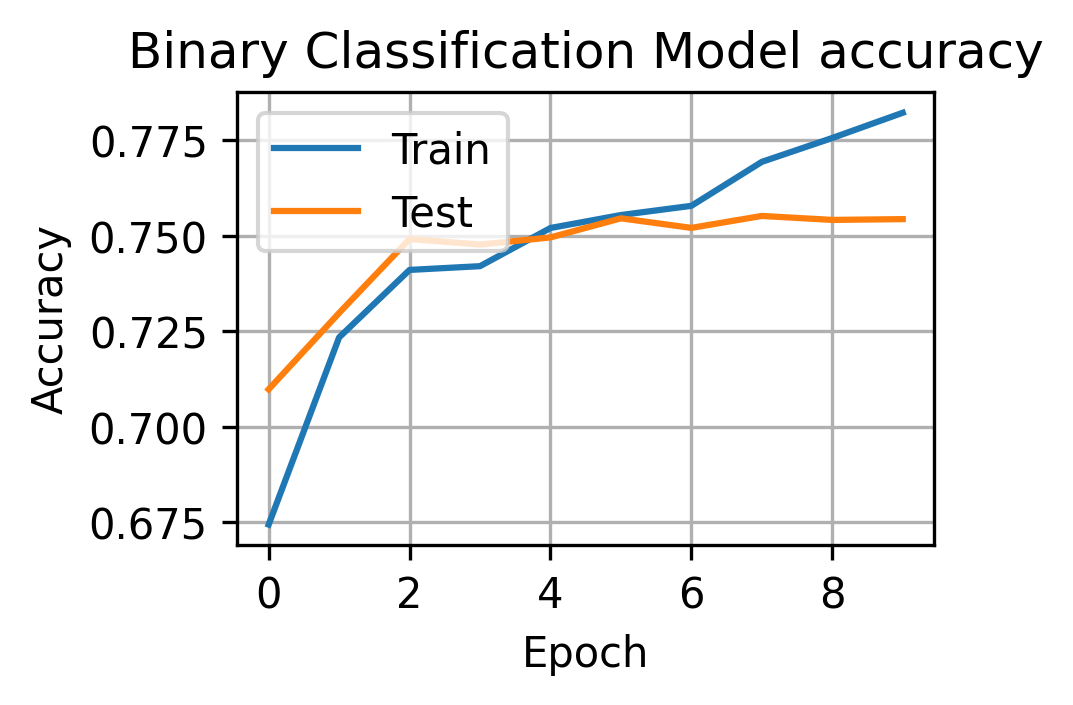

(4800,)


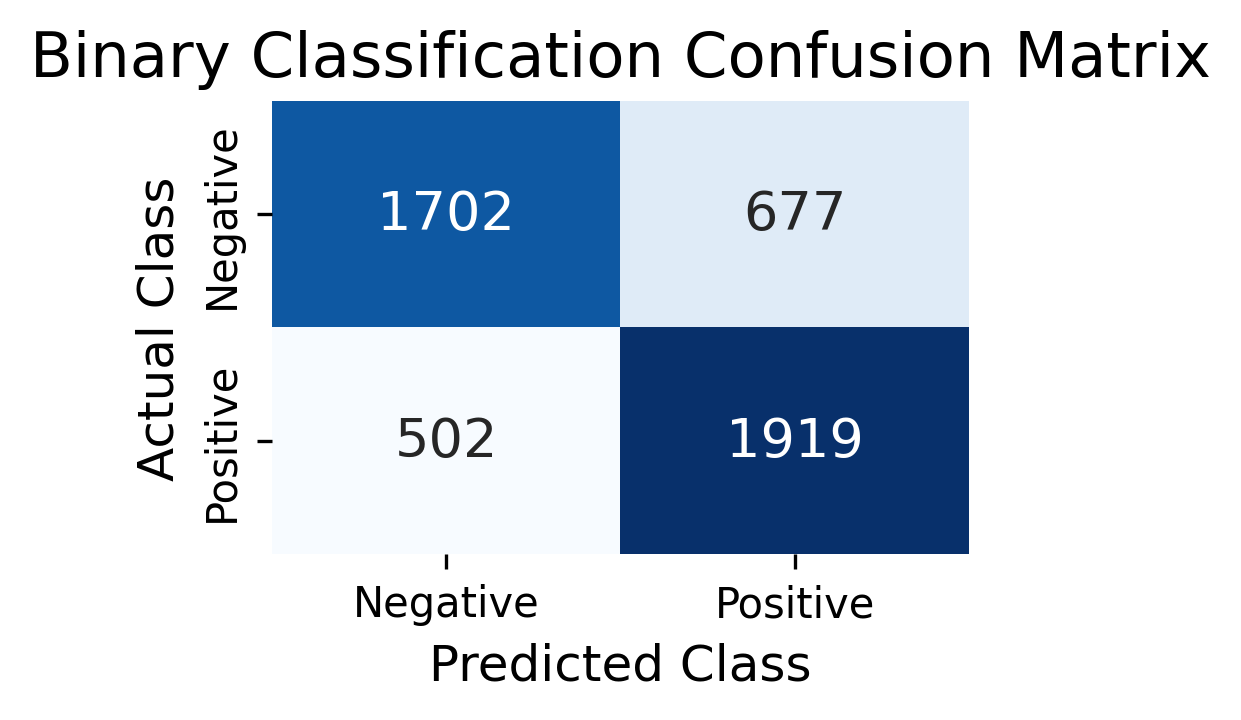

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:1378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


INFO:tensorflow:Assets written to: lyrics_mood_model/assets


INFO:tensorflow:Assets written to: lyrics_mood_model/assets


In [ ]:
# Model 2 
# Import CSV file
df = pd.read_csv('/content/drive/MyDrive/Ofir & Niv/HIT/NLP-Project/2_ML data.csv', usecols=['lyrics', 'Mood'])

X_data_seq_padded, y_data, word_index ,max_num_tokens = processTrainingData(df) 
vocab_num_words, embedding_dim, embedding_matrix = preTrainedGloVeEmbedding(word_index)
X_train_pad, X_test_pad, y_train, y_test = trainTestSplit(X_data_seq_padded, y_data)
model , history ,X_test_pad, y_test = SecModel(X_train_pad,X_test_pad,y_train,y_test,vocab_num_words,embedding_dim,embedding_matrix,max_num_tokens)
plot_model(model, show_shapes=True, rankdir="LR")
plotTrainingModelaccuracy(history)
plotConfusionMatrix(model, X_test_pad, y_test)
saveModelInfo(model, history)


In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
# from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
from keras.models import load_model 
# # Load the model
reconstructed_model =load_model("lyrics_mood_model")
predIdxs
# predictions = reloaded_model.predict(input_dict)

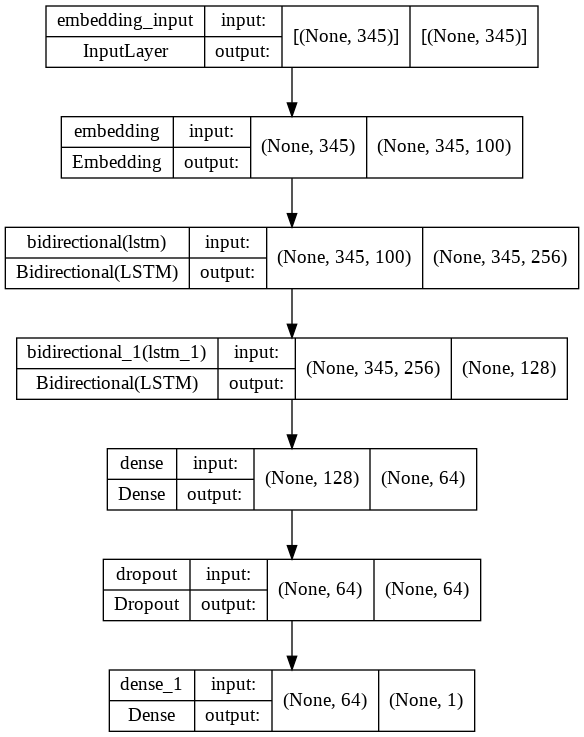

In [ ]:
plot_model(model, show_shapes=True)
# plot_model(model, show_shapes=True, rankdir="LR")



In [ ]:
def createFirstModelAndCompute(X_train_pad,X_test_pad,y_train,y_test,vocab_num_words,embedding_dim,embedding_matrix,max_num_tokens):

# Defines the Binary model1, compiles and trains it
  
  model1 = Sequential()
  embedding_layer = Embedding(vocab_num_words, 
                                embedding_dim, 
                                embeddings_initializer=Constant(embedding_matrix), 
                                input_length=max_num_tokens,
                                trainable=False)
  model1.add(embedding_layer)
  model1.add(Dropout(0.2))
  model1.add(Conv1D(32,7, activation='relu'))
  model1.add(GlobalMaxPooling1D())
  model1.add(Dense(16, activation='relu'))
  model1.add(Dense(8, activation='relu'))
  model1.add(Dense(1, activation='sigmoid'))
  model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  # Plot the model1
  plot_model(model1, show_shapes=True, rankdir="LR")
  # model1.summary()
  
  # Saves a History object for plotting
  history1 = model1.fit(X_train_pad, y_train, batch_size=128, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

  return(model1,history1,X_test_pad, y_test)

Epoch 1/10
88/88 - 24s - loss: 0.6239 - accuracy: 0.6544 - val_loss: 0.5797 - val_accuracy: 0.7017 - 24s/epoch - 277ms/step
Epoch 2/10
88/88 - 22s - loss: 0.5427 - accuracy: 0.7338 - val_loss: 0.5441 - val_accuracy: 0.7285 - 22s/epoch - 252ms/step
Epoch 3/10
88/88 - 20s - loss: 0.5127 - accuracy: 0.7483 - val_loss: 0.5293 - val_accuracy: 0.7412 - 20s/epoch - 227ms/step
Epoch 4/10
88/88 - 20s - loss: 0.4948 - accuracy: 0.7627 - val_loss: 0.5198 - val_accuracy: 0.7496 - 20s/epoch - 229ms/step
Epoch 5/10
88/88 - 20s - loss: 0.4732 - accuracy: 0.7796 - val_loss: 0.5251 - val_accuracy: 0.7437 - 20s/epoch - 227ms/step
Epoch 6/10
88/88 - 21s - loss: 0.4541 - accuracy: 0.7902 - val_loss: 0.5236 - val_accuracy: 0.7473 - 21s/epoch - 235ms/step
Epoch 7/10
88/88 - 21s - loss: 0.4321 - accuracy: 0.8054 - val_loss: 0.5326 - val_accuracy: 0.7421 - 21s/epoch - 233ms/step
Epoch 8/10
88/88 - 22s - loss: 0.4195 - accuracy: 0.8139 - val_loss: 0.5381 - val_accuracy: 0.7402 - 22s/epoch - 250ms/step
Epoch 9/

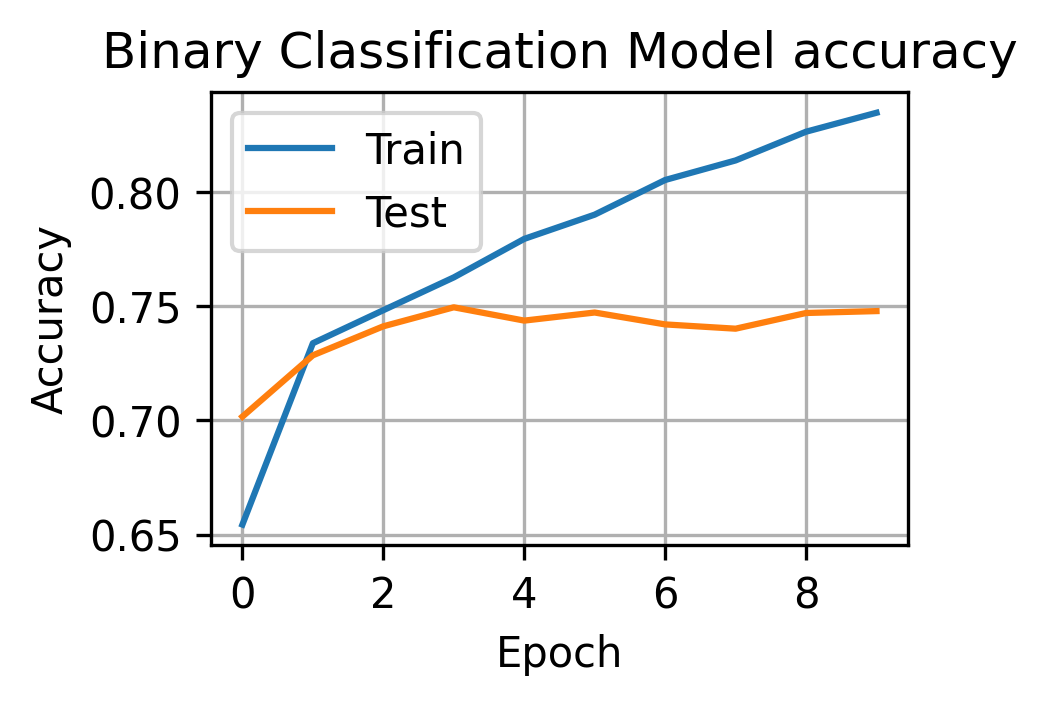

(4800,)


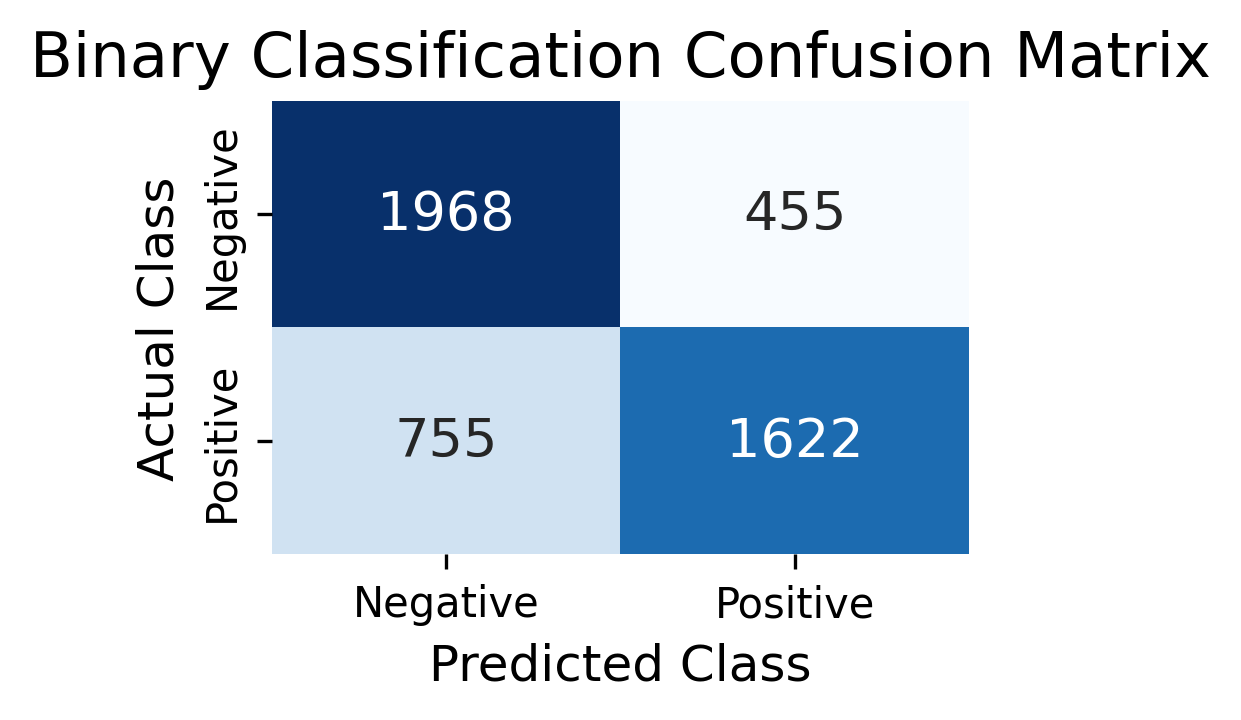

In [ ]:
# Model 1 

# Import CSV file
df = pd.read_csv('/content/drive/MyDrive/Ofir & Niv/HIT/NLP-Project/ML_DATA_3.csv', usecols=['lyrics', 'Mood'])

X_data_seq_padded, y_data, word_index ,max_num_tokens = processTrainingData(df) 
vocab_num_words, embedding_dim, embedding_matrix = preTrainedGloVeEmbedding(word_index)
X_train_pad, X_test_pad, y_train, y_test = trainTestSplit(X_data_seq_padded, y_data)
model1 , history1 ,X_test_pad, y_test = createFirstModelAndCompute(X_train_pad,X_test_pad,y_train,y_test,vocab_num_words,embedding_dim,embedding_matrix,max_num_tokens)
plot_model(model1, show_shapes=True, rankdir="LR")
plotTrainingModelaccuracy(history1)
plotConfusionMatrix(model1, X_test_pad, y_test)
# saveModelInfo(model1, history1)

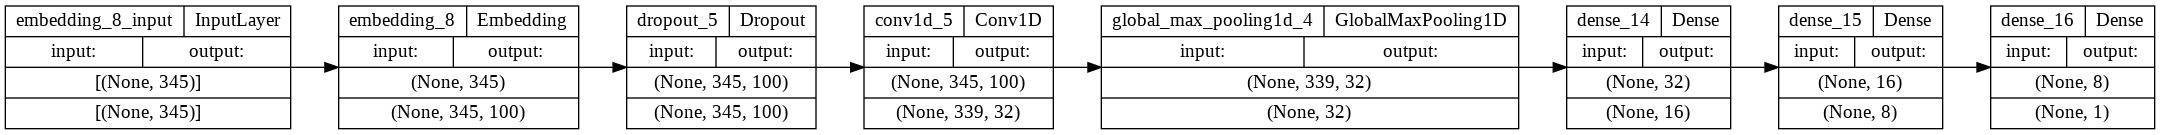

In [ ]:
plot_model(model1, show_shapes=True, rankdir="LR")
